# Project Overview

This notebook is part of the solution for the competition on Signate (Competition: [採血データを使った心不全予測](https://signate.jp/competitions/1394)). Competition id is 1394. The goal of this project is to analyze the provided dataset and build a predictive model to solve the problem. The notebook will document the steps taken in the data exploration, preprocessing, model building, and evaluation process.

The code is written in Python using popular libraries such as Pandas, Scikit-learn, and Matplotlib.

---

このノートブックは、Signateのコンペティションの解法の一部である。プロジェクトの目標は、提供されたデータセットを解析し、問題を解決する予測モデルを構築すること。このノートブックでは、データ探索、前処理、モデル構築、評価プロセスの各ステップを記録する。

コードは、Pandas、Scikit-learn、Matplotlibなどの人気ライブラリを使用して記述されている。

# Prepairing dataset

In [2]:
#installing signate API to download dataset
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f6d1623fb7a44196d0bb800278377edd5b107bf4e4d89095f327264832d9fe7f
  Stored in directory: /Users/user/Library/Caches/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [6]:
#checking files
!signate files --competition-id=1394

  fileId  name                   title                               size  updated_at
--------  ---------------------  --------------------------------  ------  -------------------
    1868  train.csv              学習用データ                       60478  2021-02-22 13:49:13
    1869  test.csv               評価用データ                       58247  2021-02-22 13:49:24
    1870  sample_submission.csv  サンプルサブミッション用ファイル    6436  2021-02-22 13:49:37


In [7]:
#Downloading files
!signate download --competition-id=1394

sample_submission.csv
100% [............................................................] 6436 / 6436
test.csv
100% [..........................................................] 58247 / 58247
train.csv
100% [..........................................................] 60478 / 60478

Download completed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [31]:
# Display the first few rows to check the data
print("Train Data:")
train_df.head()

Train Data:


,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target
0,0,56,1,5882,0,38,0,185315.0104,0.844417,134,1,0,10,1
1,3,50,0,1767,1,35,0,371620.3666,0.837448,136,0,0,187,1
2,7,41,0,250,1,30,0,372810.2084,0.819996,139,1,0,29,1
3,11,47,0,582,1,20,0,185780.6482,0.870314,137,0,0,43,0
4,12,60,0,80,0,25,0,265096.3999,0.828112,136,1,0,213,0


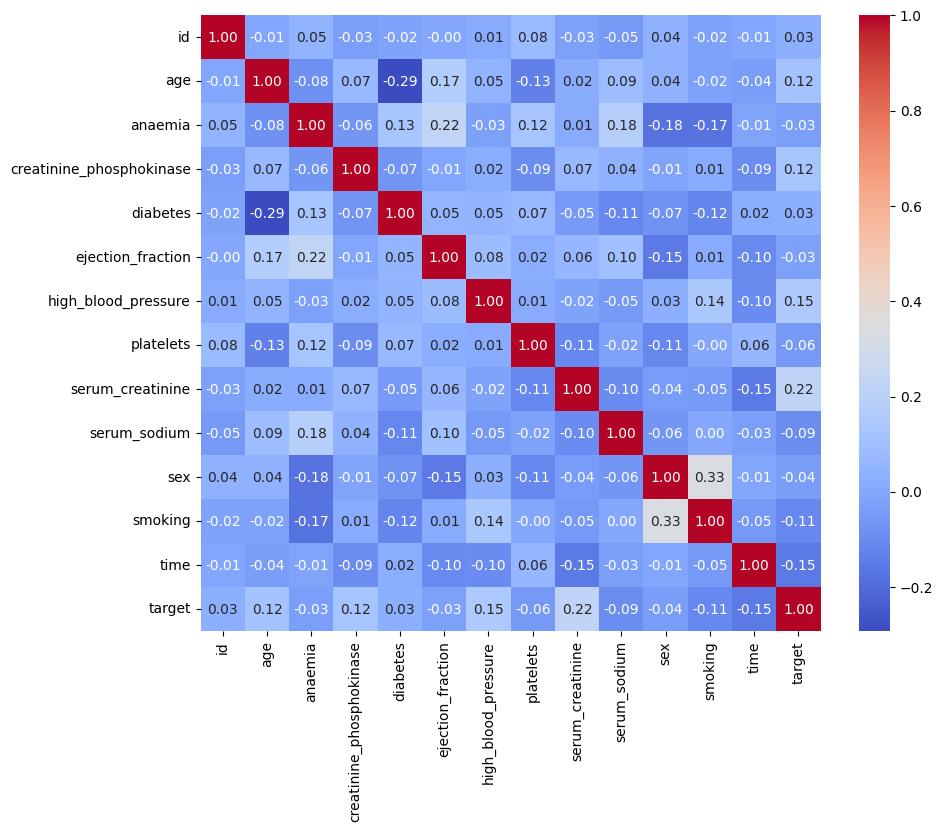

In [34]:
# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

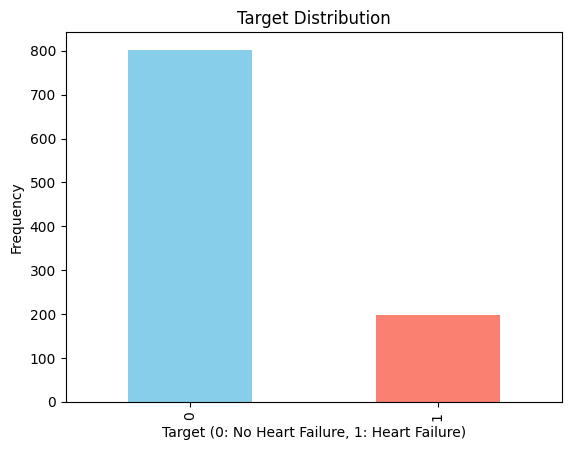

target
0    802
1    198
Name: count, dtype: int64


In [57]:
# Plot the distribution of the target variable
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()
print(train_df['target'].value_counts())

# The target distribution shows a clear imbalance, with a significant majority of 0's (No Heart Failure).

In [4]:
# Read the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df['target'].value_counts())

target
0    802
1    198
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [118]:
# Scaling the data (standardization)
# Standardize all numerical features except 'id' and 'target'
scaler = StandardScaler()
numerical_features = train_df.select_dtypes(include=[np.number]).columns

# Exclude 'id' and 'target' from scaling
numerical_features = numerical_features[numerical_features != 'id']
numerical_features = numerical_features[numerical_features != 'target']

# Scale the data
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# Balancing the classes
# Check the distribution of the target variable
print(train_df['target'].value_counts())

target
0    802
1    198
Name: count, dtype: int64


In [6]:
# Since class 0 is significantly larger, apply oversampling to class 1 (using resample)
# This is a simple approach for balancing the classes

# Split the data into two classes
class_0 = train_df[train_df['target'] == 0]
class_1 = train_df[train_df['target'] == 1]

# Upsample class 1 to match the size of class 0
class_1_upsampled = resample(class_1, 
                              replace=True,    # Allow repeated selection
                              n_samples=len(class_0),  # To match the size of class 0
                              random_state=42)  # For reproducibility

# Combine the classes back together
train_df_balanced = pd.concat([class_0, class_1_upsampled])

# Shuffle the data to avoid any ordering
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(train_df_balanced['target'].value_counts())

target
0    802
1    802
Name: count, dtype: int64


In [7]:
# Split the data into features and target variable
X = train_df_balanced.drop(columns=['target', 'id'])
y = train_df_balanced['target']

# Split the data into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

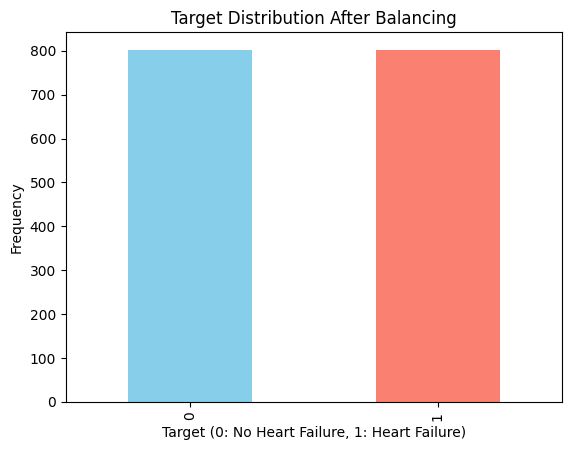

In [8]:
# Visualize the distribution of the target variable after balancing
train_df_balanced['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution After Balancing')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [75]:
# 1. Create the logistic regression model
model = LogisticRegression(random_state=42)

# 2. Train the model using the training data
model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred = model.predict(X_test)

# 4. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 7. Cross-validation to assess model performance
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Accuracy: 0.7072

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       157
           1       0.74      0.65      0.69       164

    accuracy                           0.71       321
   macro avg       0.71      0.71      0.71       321
weighted avg       0.71      0.71      0.71       321


Confusion Matrix:
[[120  37]
 [ 57 107]]

Cross-validation scores: [0.70093458 0.71962617 0.66666667 0.70093458 0.70625   ]
Mean cross-validation score: 0.6989


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# 1. Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# 2. Train the model using the training data
rf_model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 6. Confusion matrix
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# 7. Cross-validation to assess model performance
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)  # 5-fold cross-validation
print(f"\nRandom Forest Cross-validation scores: {cv_scores_rf}")
print(f"Mean cross-validation score: {cv_scores_rf.mean():.4f}")

Random Forest Accuracy: 0.9626

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       157
           1       0.95      0.98      0.96       164

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321


Random Forest Confusion Matrix:
[[149   8]
 [  4 160]]

Random Forest Cross-validation scores: [0.95950156 0.95327103 0.96884735 0.95638629 0.96875   ]
Mean cross-validation score: 0.9614


Random Forest Accuracy: 0.9626

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       157
           1       0.95      0.98      0.96       164

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321



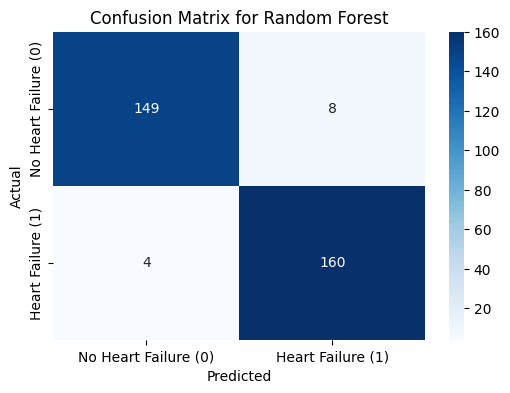

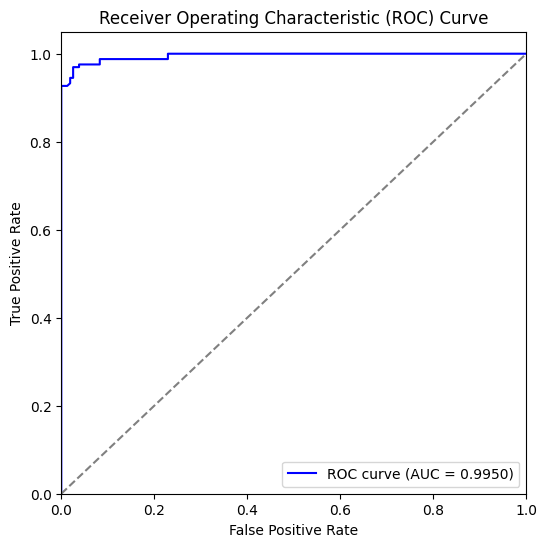

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# 2. Detailed classification report (precision, recall, f1-score)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Failure (0)', 'Heart Failure (1)'], yticklabels=['No Heart Failure (0)', 'Heart Failure (1)'])
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])  # Using probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# 1. Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# 2. Perform cross-validation (5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')  # scoring='accuracy' for classification

# 3. Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of cross-validation scores: {np.std(cv_scores):.4f}")


Cross-validation scores: [0.95950156 0.95327103 0.96884735 0.95638629 0.971875  ]
Mean cross-validation score: 0.9620
Standard deviation of cross-validation scores: 0.0072


In [90]:
from sklearn.model_selection import GridSearchCV

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Настройка GridSearchCV для RandomForest
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')

# Обучение на всех возможных комбинациях гиперпараметров
grid_search.fit(X_train, y_train)

# Печать лучших параметров и лучшего результата
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9470026750972762


Best Random Forest Accuracy on Test Data: 0.9595

Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       157
           1       0.95      0.98      0.96       164

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321



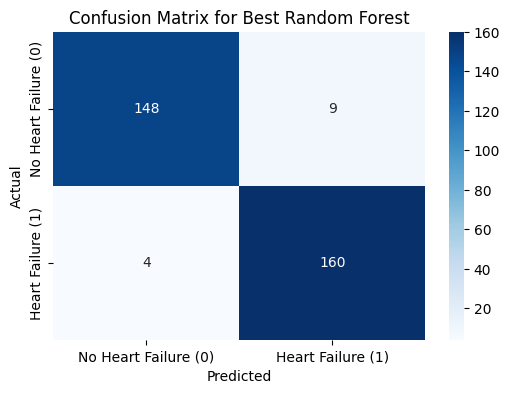

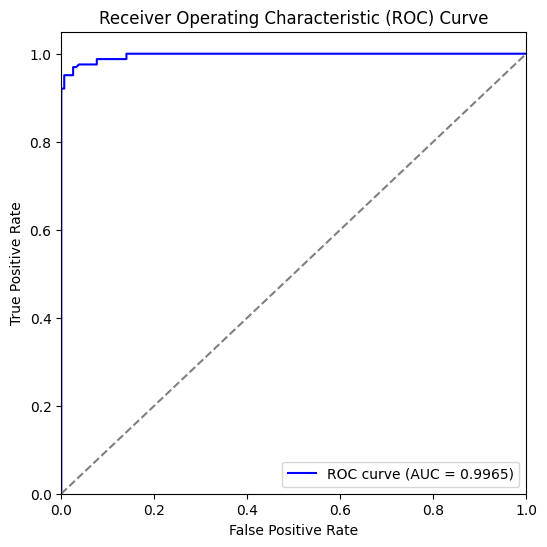

In [91]:
# Обучение модели с лучшими параметрами
best_rf_model = grid_search.best_estimator_

# 1. Оценка на тестовых данных
y_pred_best_rf = best_rf_model.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Best Random Forest Accuracy on Test Data: {accuracy_best_rf:.4f}")

# 2. Classification report
print("\nBest Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

# 3. Confusion matrix
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Failure (0)', 'Heart Failure (1)'], yticklabels=['No Heart Failure (0)', 'Heart Failure (1)'])
plt.title('Confusion Matrix for Best Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [96]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:0000:0100:01


XGBoost Accuracy: 0.9346

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       157
           1       0.90      0.99      0.94       164

    accuracy                           0.93       321
   macro avg       0.94      0.93      0.93       321
weighted avg       0.94      0.93      0.93       321



/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:22:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


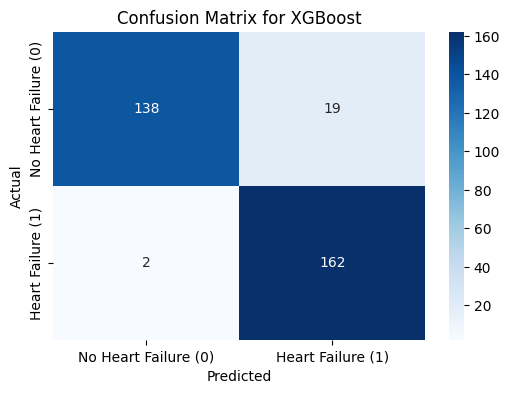

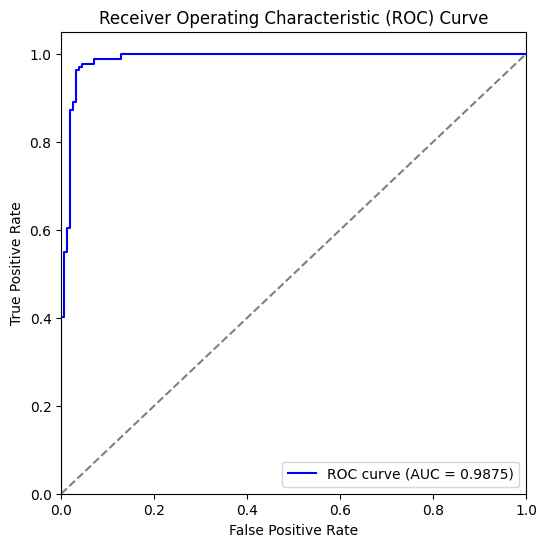

In [116]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score


# 1. Создаем модель XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# 2. Обучаем модель на тренировочных данных
xgb_model.fit(X_train, y_train)

# 3. Сделаем предсказания на тестовых данных
y_pred_xgb = xgb_model.predict(X_test)

# 4. Оценка точности
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# 6. Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Failure (0)', 'Heart Failure (1)'], yticklabels=['No Heart Failure (0)', 'Heart Failure (1)'])
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])  # Using probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [104]:
test_df = pd.read_csv('test.csv')
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
y_pred_test = xgb_model.predict(test_df.drop(columns=['id']))
y_pred_test

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Gradient Boosting Accuracy: 0.8972

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       157
           1       0.87      0.93      0.90       164

    accuracy                           0.90       321
   macro avg       0.90      0.90      0.90       321
weighted avg       0.90      0.90      0.90       321



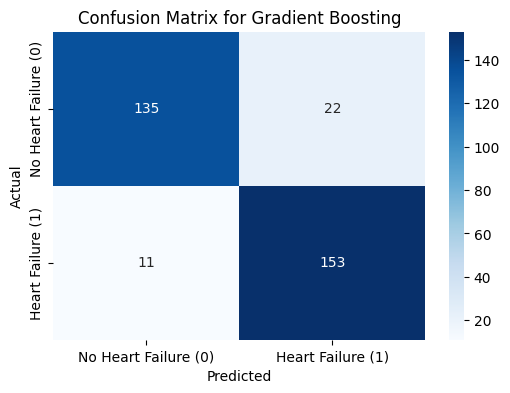

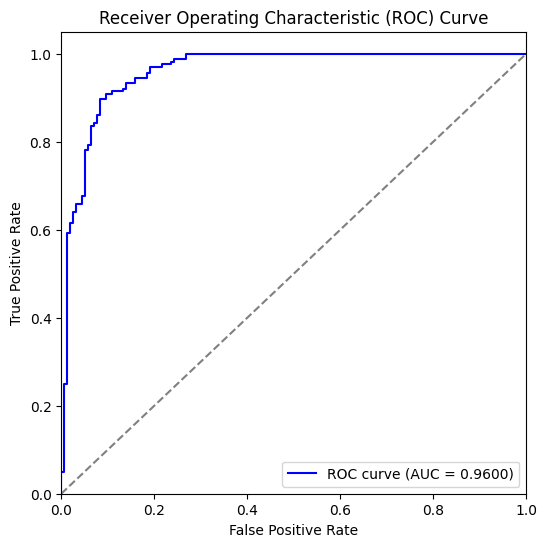

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Создаем модель Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Обучаем модель на тренировочных данных
gb_model.fit(X_train, y_train)

# 3. Сделаем предсказания на тестовых данных
y_pred_gb = gb_model.predict(X_test)

# 4. Оценка точности
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# 6. Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Failure (0)', 'Heart Failure (1)'], yticklabels=['No Heart Failure (0)', 'Heart Failure (1)'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1])  # Using probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Result saving

In [105]:
test_df = pd.read_csv('test.csv')
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
y_pred_test = xgb_model.predict(test_df.drop(columns=['id']))
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'target': y_pred_test 
})
submission_df.to_csv('submission.csv', header=False, index=False)

In [106]:
# Загружаем оба файла без заголовков
submission = pd.read_csv('submission_random_forrest_v1.csv', header=None)
submission1 = pd.read_csv('submission_xgb_model_v2.csv', header=None)

# Сравниваем строки и считаем количество отличий
differences = (submission[1] != submission1[1 ]).sum()

# Выводим количество отличающихся ответов
print(f"Number of differing answers: {differences}")

Number of differing answers: 198


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Шаг 5. Инициализация моделей
# Модель RandomForest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Модель Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
# Модель XGBoost (параметры можно настроить при необходимости)
xgb_clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Шаг 6. Создание ансамблевого классификатора с мягким голосованием
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf)],
    voting='soft'  # Используем soft voting: усредняем вероятности предсказаний моделей
)

# Шаг 7. Обучение ансамблевой модели
ensemble_clf.fit(X_train, y_train)

# Шаг 8. Предсказание и оценка качества модели
y_pred = ensemble_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9439252336448598
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       157
           1       0.91      0.99      0.95       164

    accuracy                           0.94       321
   macro avg       0.95      0.94      0.94       321
weighted avg       0.95      0.94      0.94       321



/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:27:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [16]:
test_df = pd.read_csv('test.csv')
y_pred_test = ensemble_clf.predict(test_df.drop(columns=['id']))
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'target': y_pred_test 
})
submission_df.to_csv('submission_ensemble_v1.csv', header=False, index=False)

In [17]:
# Загружаем оба файла без заголовков
submission = pd.read_csv('submission_ensemble_v1.csv', header=None)
submission1 = pd.read_csv('submission_xgb_model_v2.csv', header=None)

# Сравниваем строки и считаем количество отличий
differences = (submission[1] != submission1[1 ]).sum()

# Выводим количество отличающихся ответов
print(f"Number of differing answers: {differences}")

Number of differing answers: 28
